# mittlere Zwischenankungtszeit

In [2]:
import json
import pandas as pd
import numpy as np
import random

In [3]:
import utils.presenter as show
import utils.schedule_solver as ssv

In [4]:
from utils.checker import is_machine_conflict_free
from utils.checker import is_job_machine_sequence_correct

In [5]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
show.print_jobs(instance)

 job 0:	[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
 job 1:	[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
 job 2:	[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
 job 3:	[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
 job 4:	[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
 job 5:	[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
 job 6:	[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
 job 7:	[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
 job 8:	[[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
 job 9:	[[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



In [6]:
def get_all_machine_ids(job_shop_matrix):
    machines = set()
    for job in job_shop_matrix:
        for operation in job:
            machines.add(operation[0])
    return machines

## I) Mittlere Zwischenankunftszeit t_a

### 1. Vektor der Bearbeitungszeiten auf der Engpassmaschine

#### a) Bestimmung der Engpassmaschine (7.12)

$$
m_{\text{max}} = \arg\max_{m \in M} T_m
$$

In [11]:
def get_engpassmaschine(jobs: dict, debug=False):
    machine_usage = {}
    for job_ops in jobs.values():
        for machine, duration in job_ops:
            machine_usage[machine] = machine_usage.get(machine, 0) + duration
    if debug:
        print("\nEndstand Maschinenbelastung:", machine_usage)
    return max(machine_usage, key=machine_usage.get)

get_engpassmaschine(instance, debug = True)


Endstand Maschinenbelastung: {0: 493, 1: 548, 2: 556, 3: 631, 4: 534, 5: 416, 6: 491, 7: 499, 8: 531, 9: 410}


3

#### b) Vektor der Bearbeitungszeiten auf der Engpassmaschine erstellen

In [13]:
def get_vec_t_b_mmax(jobs: dict) -> list:
    # Engpassmaschine bestimmen
    engpassmaschine = get_engpassmaschine(jobs)

    # Vektor der Bearbeitungszeiten auf der Engpassmaschine
    vec_t_b_mmax = []
    for job in jobs.values():
        duration = next((d for m, d in job if m == engpassmaschine), 0)
        vec_t_b_mmax.append(duration)

    return vec_t_b_mmax


In [14]:
vec_t_b_mmax = get_vec_t_b_mmax(instance)
vec_t_b_mmax

[36, 69, 39, 98, 26, 95, 61, 79, 76, 52]

### 2. Job-Wahrscheinlichkeiten

In [16]:
# Gleichverteilt 
n_jobs = len(instance)
p = [1 / n_jobs] * n_jobs
p

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

### 3. Berechne die mittlere Zwischenankunftszeit t_a nach Formel (7.16)

$$
t_a = \frac{\vec{p}^T \cdot \vec{t}_{b, m_{\text{max}}}}{u_{b, m_{\text{max}}}}
$$

- $t_a$: mittlere Zwischenankunftszeit  
- $\vec{p}$: Vektor der Wahrscheinlichkeiten der Arbeitspläne (bzw. Jobs)  
- $\vec{t}_{b, m_{\text{max}}}$: Vektor der Bearbeitungszeiten auf der Engpassmaschine  
- $u_{b, m_{\text{max}}}$: gewünschte Auslastung der Engpassmaschine


In [19]:
def calculate_mean_interarrival_time(jobs: dict, u_b_mmax: float = 0.9) ->float:
    """
    Berechnet die mittlere Interarrival-Zeit t_a, sodass die Engpassmaschine
    mit Auslastung u_b_mmax (< 1.0) betrieben wird.
    """
    n_jobs = len(jobs)
    p = [1 / n_jobs] * n_jobs
    vec_t_b_mmax = get_vec_t_b_mmax(jobs)
    t_a = sum(p[i] * vec_t_b_mmax[i] for i in range(n_jobs)) / u_b_mmax
    return np.round(t_a, 2)


In [20]:
t_a =  calculate_mean_interarrival_time(instance, u_b_mmax = 0.9)
t_a

70.11

## II) Ankunftszeiten

#### Generierung eine zufällige Job-Reihenfolge

In [23]:
job_names = list(instance.keys())
n_jobs = len(job_names)

# Permutiere Jobnamen
np.random.seed(12)
shuffled_jobs = list(np.random.permutation(job_names))
shuffled_jobs

['job 5',
 'job 8',
 'job 7',
 'job 0',
 'job 4',
 'job 9',
 'job 3',
 'job 2',
 'job 1',
 'job 6']

#### Generierung exponentiell verteilte Zwischenankunftszeiten mit Mittelwert t_a

In [25]:
np.random.seed(123)
interarrival_times = np.random.exponential(scale=t_a, size=n_jobs)

# Berechne absolute Ankunftszeiten
arrival_times = np.cumsum(interarrival_times)
arrival_times = np.round(arrival_times, 2)

# Kombiniere Reihenfolge und Zeitpunkte
job_arrivals = list(zip(shuffled_jobs, arrival_times))

# Ausgabe als DataFrame
df_arrivals = pd.DataFrame(job_arrivals, columns=["Job-ID", "Ankunftszeit (Minuten)"])
df_arrivals = df_arrivals.sort_values(by="Ankunftszeit (Minuten)").reset_index(drop=True)
df_arrivals

,Job-ID,Ankunftszeit (Minuten)
0,job 5,83.59
1,job 8,107.22
2,job 7,125.26
3,job 0,181.45
4,job 4,270.56
5,job 9,309.13
6,job 3,586.13
7,job 2,667.09
8,job 1,713.06
9,job 6,747.96


## III) Scheduling

### a) First Come First Serve

In [28]:
# FCFS mit Ankunftszeiten berücksichtigen
def schedule_fcfs_with_arrivals(jobs: dict, arrival_df: pd.DataFrame):
    """
    FCFS-Scheduling mit Ankunftszeiten, auf Basis eines Job-Dictionaries.
    """
    num_jobs = len(jobs)
    
    # Ankunftszeiten als Dict: {"job 0": 83.59, ...}
    arrival_times = arrival_df.set_index("Job-ID")["Ankunftszeit (Minuten)"].to_dict()
    
    # Initialisierungen
    job_ready = {job_id: arrival_times[job_id] for job_id in jobs}
    machine_ready = {}
    schedule = []

    # Jobs nach Ankunftszeit sortieren
    sorted_jobs = arrival_df.sort_values(by="Ankunftszeit (Minuten)")["Job-ID"].tolist()

    # FCFS: bearbeite Jobs der Reihe nach
    for job_id in sorted_jobs:
        for machine, duration in jobs[job_id]:
            start = max(job_ready[job_id], machine_ready.get(machine, 0))
            end = start + duration

            schedule.append({
                'Job': f'{job_id}',
                'Machine': f'M{machine}',
                'Start': start,
                'Duration': duration,
                'End': end
            })

            job_ready[job_id] = end
            machine_ready[machine] = end

    return pd.DataFrame(schedule)



In [29]:
df_fcfs = schedule_fcfs_with_arrivals(instance, df_arrivals)
df_fcfs

,Job,Machine,Start,Duration,End
0,job 5,M2,83.59,84,167.59
1,job 5,M1,167.59,2,169.59
2,job 5,M5,169.59,52,221.59
3,job 5,M3,221.59,95,316.59
4,job 5,M8,316.59,48,364.59
...,...,...,...,...,...
95,job 6,M5,3275.59,21,3296.59
96,job 6,M9,3296.59,32,3328.59
97,job 6,M8,3328.59,89,3417.59
98,job 6,M7,3417.59,30,3447.59


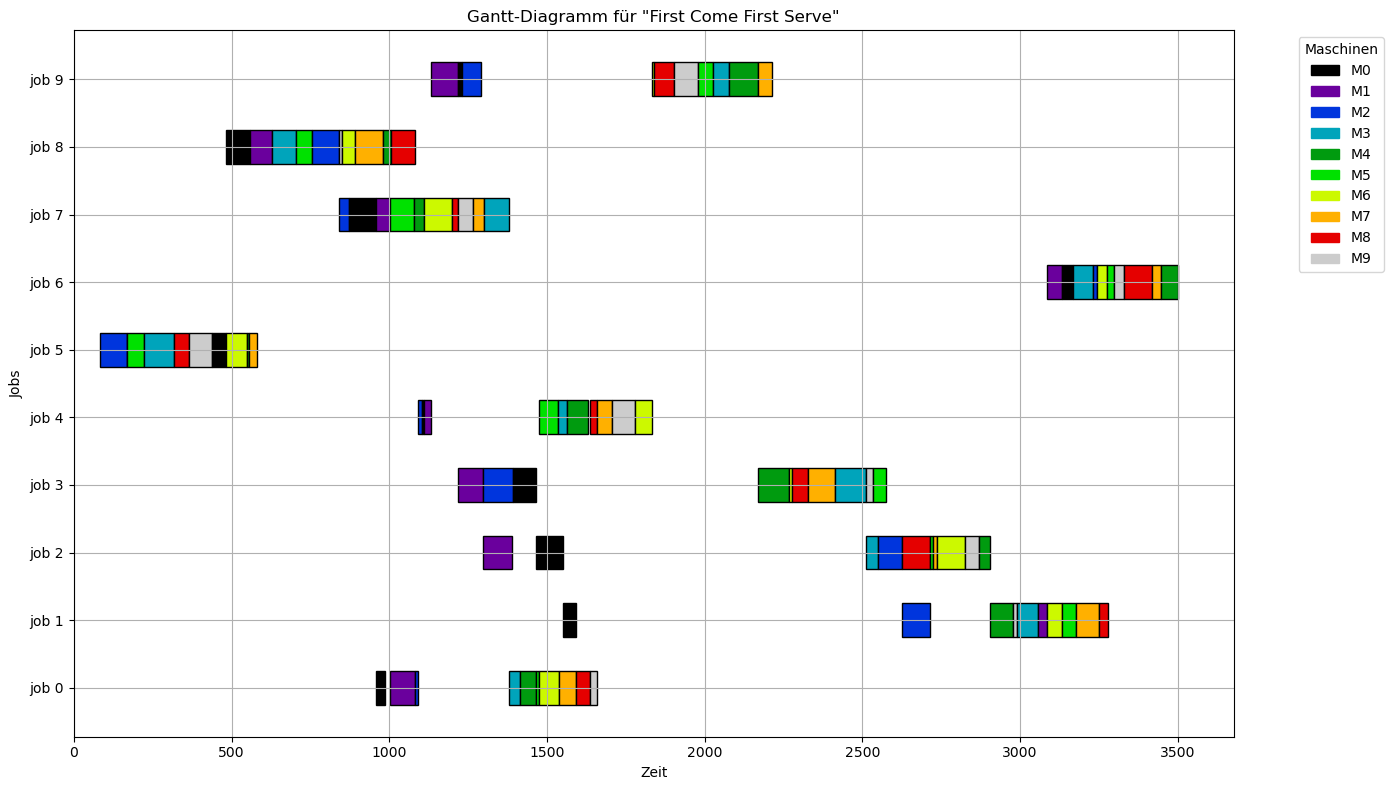

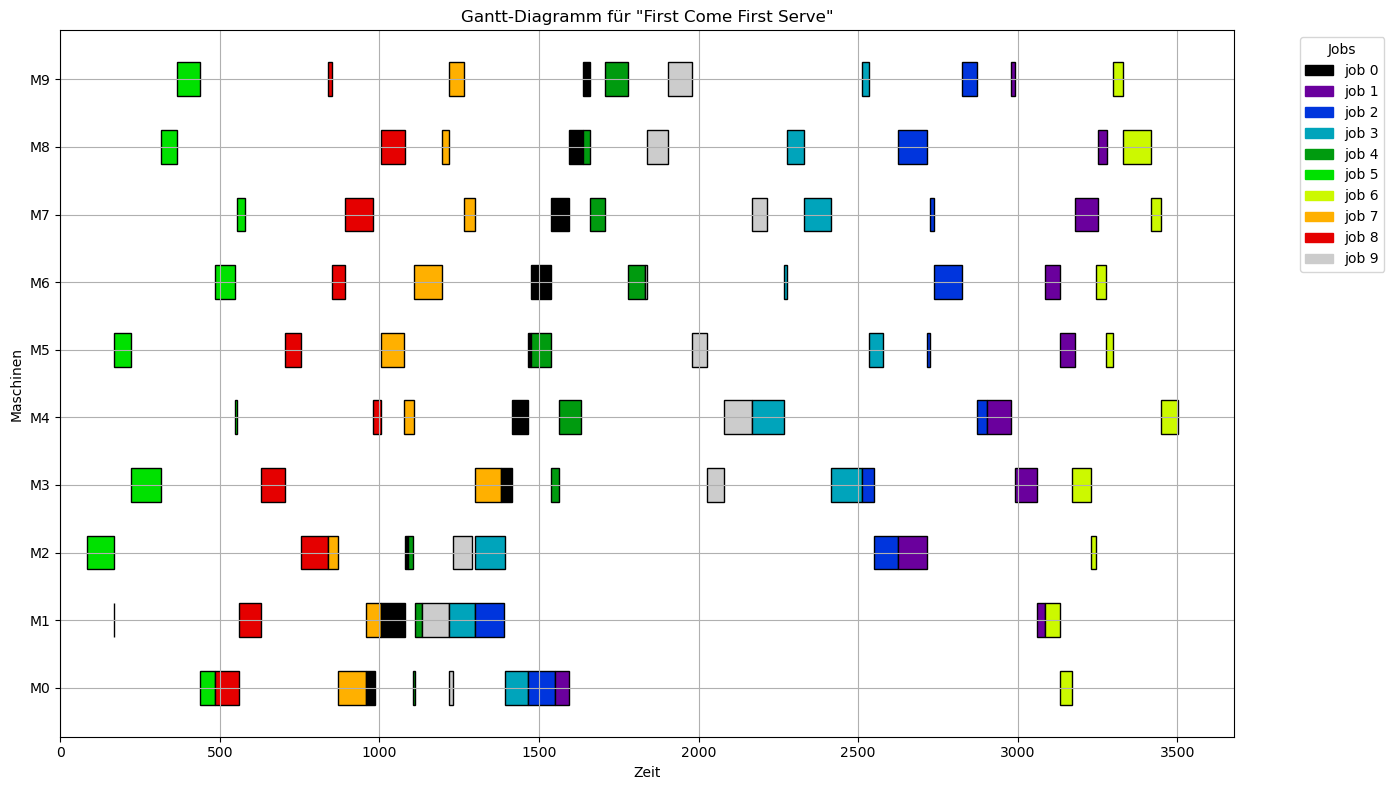

In [30]:
category = "First Come First Serve"

show.plot_gantt_jobs(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category))

In [31]:
is_machine_conflict_free(df_fcfs)
is_job_machine_sequence_correct(df_fcfs, instance)

True

### b) HiGHS

In [33]:
df_schedule_highs, makespan = ssv.solve_jssp_global_makespan(instance, df_arrivals, solver_time_limit=300)
df_schedule_highs.sort_values(by="Start").reset_index(drop=True)
df_schedule_highs

,Job,Machine,Day-ID,Start,Duration,End
0,job 0,M0,0,410.56,29,439.56
1,job 0,M1,0,443.56,78,521.56
2,job 0,M2,0,658.13,9,667.13
3,job 0,M3,0,728.13,36,764.13
4,job 0,M4,0,808.22,49,857.22
...,...,...,...,...,...,...
95,job 9,M9,0,543.22,76,619.22
96,job 9,M5,0,619.22,47,666.22
97,job 9,M3,0,666.22,52,718.22
98,job 9,M4,0,718.22,90,808.22


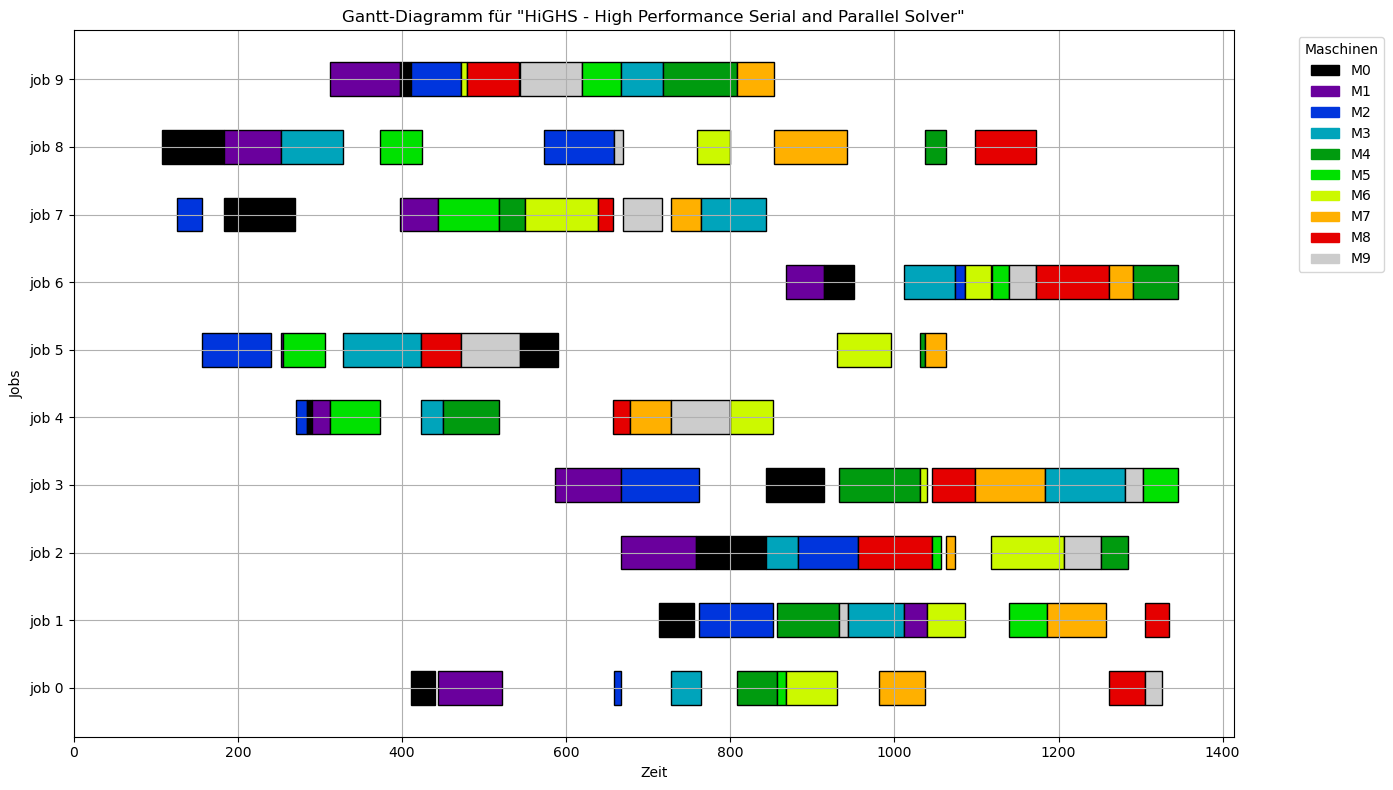

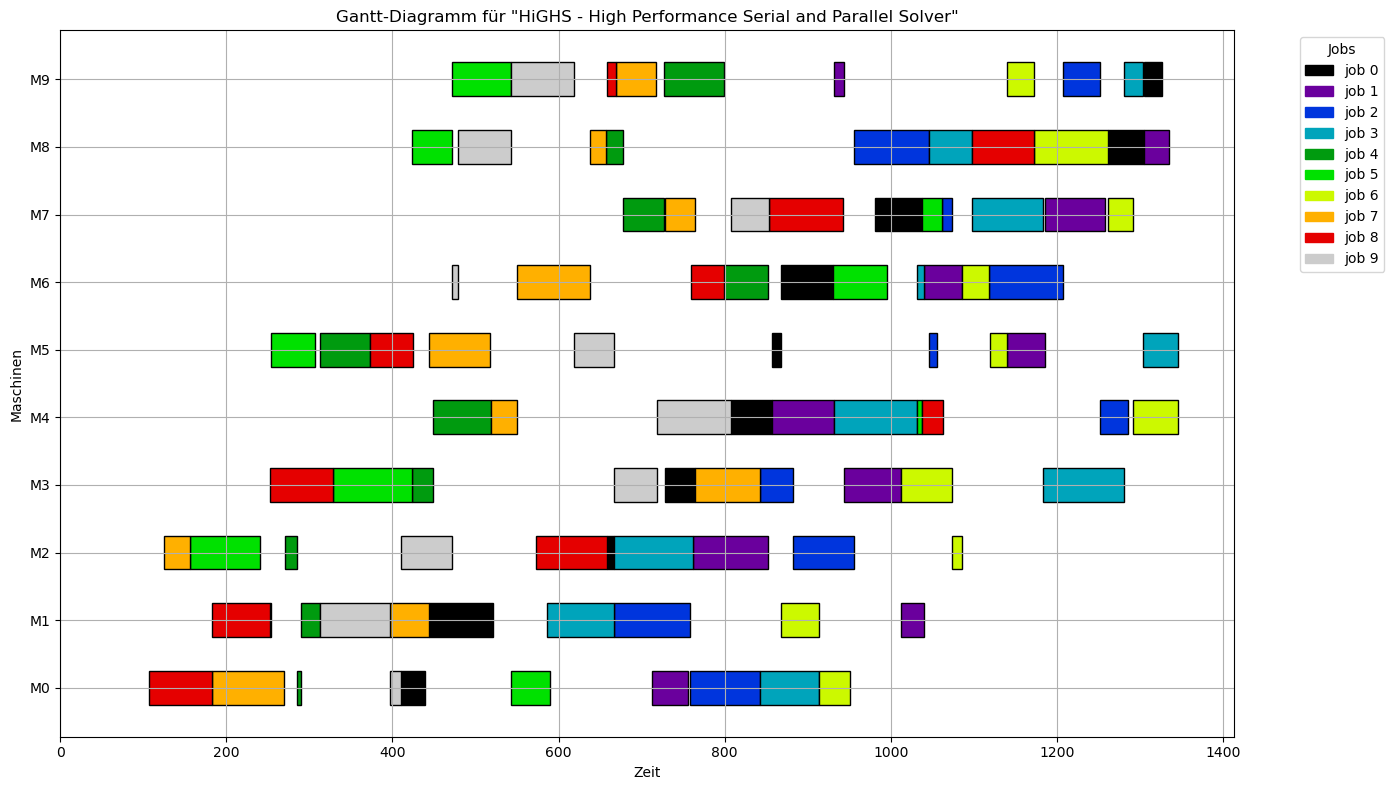

True

In [34]:
category = "HiGHS - High Performance Serial and Parallel Solver"

show.plot_gantt_jobs(df_schedule_highs, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_schedule_highs, 'Gantt-Diagramm für "{}"'.format(category))

is_machine_conflict_free(df_schedule_highs)
is_job_machine_sequence_correct(df_schedule_highs, instance)

### Export

In [37]:
df_schedule_highs.to_csv("data/02_schedule.csv", index = False)